# NYC MTA: Most common Venues categories near metro entrances 
NYC Metropolitan Transportation Authority (MTA) needs a strategy to alleviating traffic. Furthermore, if more people use public transportation, gain would raise and it could be spent to pay for a major overhaul of the aging subway.
One way to do this is to make New Yorkers use the subway instead of other road-kind transportation.
One solution could be to make agreements with venues near metro entrances in order to give special offers to New Yorkers who use the subway. What is proposed and presented in this report is how to choose the venues categories:
- Venues has to be near the metro entrance, in this case we chose a radius of 500 m. 
- Best venues are the one more popular, because they have more appeal.

In [148]:
import pandas as pd
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import folium
from branca.element import Template, MacroElement
import requests
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.colors as colors

## Functions definition

In [2]:
#Use Foursquare API to get recommended venues near a given location
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        try:
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT)
                
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print('ERROR for row {}'.format(name))

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Subway Entrance', 
                  'Subway Entrance Latitude', 
                  'Subway Entrance Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [3]:
def chooseKSilhouette(X,k_max):
    #range_n_clusters = [2, 3, 4, 5, 6]
    
    for n_clusters in range(11,k_max):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
    
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
    
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
    
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    
            ith_cluster_silhouette_values.sort()
    
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
    
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
    
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
    
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
    
        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X.values[:, 0], X.values[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')
    
        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')
    
        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')
    
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")
    
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
    
    plt.show()

In [4]:
#Order for most common venue
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [5]:
#Find best K for K-means clustering (elbow method)
def k_means_find_best_k(df,k_max):
    app={}
    for k in range (2, k_max):
        #Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
        kmeans_model = KMeans(init="k-means++", n_init=20, n_clusters=k, random_state=10).fit(df)
        #algorithm="elkan"
    
        # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
        labels = kmeans_model.labels_
        cluster_labels=kmeans_model.fit_predict(df)
        # Sum of distances of samples to their closest cluster center
        #dist=sum(np.min(cdist(df, kmeans_model.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0]
        dist=kmeans_model.inertia_
        #dist=kmeans_model.score(df)
        app[k]= dist

    return(app)

In [6]:
def getNumberString(number):
    if number==1:
        return('1st')
    elif number ==2:
        return('2nd')
    elif number ==3:
        return('3rd')
    else:
        return('{}th'.format(str(number)))

In [210]:
def getClusterCommonVenues(dfIn,numberOfclusters,numberOfCommons,positions):
    fieldNames=' Most Common Venue'
    listOutput=[]
    for clusterNumber in range (0,numberOfclusters):
        for number in range(1,numberOfCommons):
            fieldName=getNumberString(number)+fieldNames
            numberOfClusterComponents=dfIn.loc[dfIn['Cluster Labels']==clusterNumber][fieldName].size
            counts=dfIn.loc[dfIn['Cluster Labels']==clusterNumber][fieldName].value_counts()  
            
            types=''
            countTypes=''
            for pos in range(0,positions):
                try:
                    if types=='':
                        types=str(counts.index[pos])
                        countTypes=str(counts[pos])
                    else:
                        types=types+'; '+str(counts.index[pos])
                        countTypes=countTypes+'; '+str(counts[pos])
                except:
                    dummy=1
            if types!='':
                listOutput.append([clusterNumber,fieldName,types,countTypes,numberOfClusterComponents])
        
    dfOutput=pd.DataFrame(listOutput)
    dfOutput.columns=['Cluster','Venue Position','Venue Type','Counts','Total']
    dfOutput.set_index('Cluster',inplace=True)
    return(dfOutput)

## Files

In [208]:
fileNYSubway='dataSets/DOITT_SUBWAY_ENTRANCE_01_13SEPT2010.csv' #kaggle
fileVenues='dataSets/NY_entrance_venues2.csv' #Foursquare APIs results written in order to not exceed dayly API calls
fileRes='res/cluster_char.csv'
#fileVenues='dataSets/NY_entrance_venues_200.csv' #Foursquare APIs results written in order to not exceed dayly API calls

## Load subway entrances
Load Kaggle dataset + data preparation

In [9]:
dfSubway=pd.read_csv(fileNYSubway)

In [10]:
dfSubway.shape

(1928, 5)

In [11]:
dfSubway.head()

,OBJECTID,URL,NAME,the_geom,LINE
0,1734,http://web.mta.info/nyct/service/,Birchall Ave & Sagamore St at NW corner,POINT (-73.86835600032798 40.84916900104506),2-5
1,1735,http://web.mta.info/nyct/service/,Birchall Ave & Sagamore St at NE corner,POINT (-73.86821300022677 40.84912800131844),2-5
2,1736,http://web.mta.info/nyct/service/,Morris Park Ave & 180th St at NW corner,POINT (-73.87349900050798 40.84122300105249),2-5
3,1737,http://web.mta.info/nyct/service/,Morris Park Ave & 180th St at NW corner,POINT (-73.8728919997833 40.84145300067447),2-5
4,1738,http://web.mta.info/nyct/service/,Boston Rd & 178th St at SW corner,POINT (-73.87962300013866 40.84081500075867),2-5


### Get latitute and longitude of metro entrance
Using the_geom field

In [12]:
latitudes=[]
longitudes=[]
for coordinates in dfSubway['the_geom']:
    lista=coordinates.split(' ')
    latitudes.append(float(lista[2].replace(')','')))
    longitudes.append(float(lista[1].replace('(','')))

In [13]:
dfSubway['Latitude']=latitudes
dfSubway['Longitude']=longitudes

In [14]:
dfSubwayEntrances=dfSubway[['NAME','Latitude','Longitude']]

In [15]:
dfSubwayEntrances.head()

,NAME,Latitude,Longitude
0,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356
1,Birchall Ave & Sagamore St at NE corner,40.849128,-73.868213
2,Morris Park Ave & 180th St at NW corner,40.841223,-73.873499
3,Morris Park Ave & 180th St at NW corner,40.841453,-73.872892
4,Boston Rd & 178th St at SW corner,40.840815,-73.879623


### Change columns name

In [16]:
dfSubwayEntrances.columns=['Subway Entrance','Latitude','Longitude']

### Check for NaN and drop them

In [17]:
dfSubwayEntrances.isnull().values.any()

True

In [18]:
dfSubwayEntrances.shape

(1928, 3)

In [19]:
dfSubwayEntrances.dropna(axis=0,how='any',inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
dfSubwayEntrances.shape

(1899, 3)

In [21]:
dfSubwayEntrances.isnull().values.any()

False

### Select subset of 400 entrances

In [22]:
dfSubwayEntrances.drop_duplicates(subset='Subway Entrance', keep='first', inplace=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
dfSubwayEntrances.shape

(1597, 3)

In [24]:
dfSubwayEntrances=dfSubwayEntrances.head(400)

In [25]:
dfSubwayEntrances['Subway Entrance'].unique().size

400

In [26]:
dfSubwayEntrances['Subway Entrance'].size

400

In [27]:
dfSubwayEntrances.head()

,Subway Entrance,Latitude,Longitude
0,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356
1,Birchall Ave & Sagamore St at NE corner,40.849128,-73.868213
2,Morris Park Ave & 180th St at NW corner,40.841223,-73.873499
4,Boston Rd & 178th St at SW corner,40.840815,-73.879623
5,Boston Rd & E Tremont Ave at NW corner,40.840434,-73.880005


### Map underground entrances

In [28]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


In [29]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)
#add markers to map
for lat, lng, name in zip(dfSubwayEntrances['Latitude'], dfSubwayEntrances['Longitude'], dfSubwayEntrances['Subway Entrance']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork)  
    
map_newyork

## Get nearby venues

Client secret and id (mask for privacy)

In [30]:
CLIENT_ID='?????'
CLIENT_SECRET='?????'
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ?????
CLIENT_SECRET:?????


### Call Foursquare API
NB: Cell commented because once the venues were found, I wrote results to file so that I shouldn't use the API another time (for dayly limit)

In [31]:
#dfSubwayEntrancesVenues = getNearbyVenues(names=dfSubwayEntrances['Subway Entrance'],
#                                   latitudes=dfSubwayEntrances['Latitude'],
#                                   longitudes=dfSubwayEntrances['Longitude']
#                                  )

In [32]:
#dfSubwayEntrancesVenues.to_csv(fileVenues,sep=',',index=False)

In [113]:
dfSubwayEntrancesVenues=pd.read_csv(fileVenues)

In [114]:
dfSubwayEntrancesVenues.head()

,Unnamed: 0,Subway Entrance,Subway Entrance Latitude,Subway Entrance Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356,Bronx Park East,40.849164,-73.868453,Park
1,1,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356,Park Billiards,40.850970,-73.867792,Pool Hall
2,2,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356,Morris Park Pizza,40.844962,-73.867606,Pizza Place
3,3,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356,New Morris Deli,40.846529,-73.863874,Deli / Bodega
4,4,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356,Cafe Colonial,40.852495,-73.867654,Spanish Restaurant


### One hot encoding

In [115]:
# one hot encoding
subwayOneHot = pd.get_dummies(dfSubwayEntrancesVenues[['Venue Category']], prefix="", prefix_sep="")

# add Subway Entrance column back to dataframe
subwayOneHot['Subway Entrance'] = dfSubwayEntrancesVenues['Subway Entrance']

# move Subway Entrance column to the first column
indexNeigh=subwayOneHot.columns.get_loc("Subway Entrance")
fixed_columns = [subwayOneHot.columns[indexNeigh]] + list(subwayOneHot.columns[:indexNeigh])
subway_OneHot = subwayOneHot[fixed_columns]

subway_OneHot.head(2)

,Subway Entrance,Accessories Store,Adult Boutique,African Restaurant,Airport Lounge,Airport Tram,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Watch Shop,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Birchall Ave & Sagamore St at NW corner,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Birchall Ave & Sagamore St at NW corner,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
subway_OneHot_grouped = subway_OneHot.groupby('Subway Entrance').mean().reset_index()

In [117]:
subway_OneHot_grouped.head(2)

,Subway Entrance,Accessories Store,Adult Boutique,African Restaurant,Airport Lounge,Airport Tram,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Watch Shop,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,103rd St & Roosevelt Ave at NE corner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,103rd St & Roosevelt Ave at SE corner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Get 10 top venues

In [118]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Subway Entrance']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
subway_sorted = pd.DataFrame(columns=columns)
subway_sorted['Subway Entrance'] = subway_OneHot_grouped['Subway Entrance']

for ind in np.arange(subway_OneHot_grouped.shape[0]):
    subway_sorted.iloc[ind, 1:] = return_most_common_venues(subway_OneHot_grouped.iloc[ind, :], num_top_venues)

subway_sorted.head()

,Subway Entrance,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,103rd St & Roosevelt Ave at NE corner,Latin American Restaurant,Mexican Restaurant,Deli / Bodega,Pizza Place,Pharmacy,Food Truck,South American Restaurant,Bank,Gym,Coffee Shop
1,103rd St & Roosevelt Ave at SE corner,Latin American Restaurant,Mexican Restaurant,Deli / Bodega,Pizza Place,Pharmacy,Food Truck,South American Restaurant,Bank,Gym,Coffee Shop
2,104th St & Jamaica Ave at NE corner,Peruvian Restaurant,Deli / Bodega,Chinese Restaurant,Liquor Store,Bakery,Moving Target,Lounge,Bookstore,Park,Bagel Shop
3,104th St & Jamaica Ave at SE corner,Peruvian Restaurant,Deli / Bodega,Chinese Restaurant,Pharmacy,Convenience Store,Mexican Restaurant,Metro Station,Park,Bar,Market
4,10th Ave & 207th St at NW corner,Lounge,Pizza Place,Café,Grocery Store,Mexican Restaurant,Juice Bar,Nightclub,Food Truck,Bank,Bakery


## Clusterization : K-Means

In [119]:
subway_OneHot_grouped_clustering = subway_OneHot_grouped.drop('Subway Entrance', 1)

In [120]:
subway_OneHot_grouped_clustering.head()

,Accessories Store,Adult Boutique,African Restaurant,Airport Lounge,Airport Tram,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Watch Shop,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.028571,0.014286,0.0,0.0,0.014286,0.0,0.0


In [121]:
subway_OneHot_grouped_clustering = StandardScaler().fit(subway_OneHot_grouped_clustering).transform(subway_OneHot_grouped_clustering)

### Find best k with the elbow method and silhouette analysis

In [187]:
k_costs=k_means_find_best_k(subway_OneHot_grouped_clustering,16)
df_kcosts=pd.DataFrame.from_dict(k_costs,orient='index').reset_index()
df_kcosts.columns=['k','Inertia']

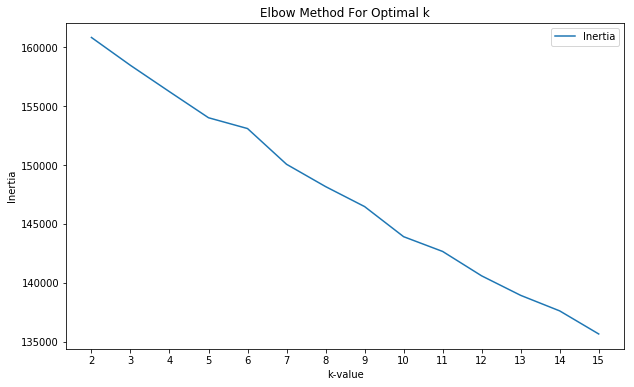

In [188]:
df_kcosts.plot(kind='line', x='k', y='Inertia', figsize=(10, 6))
plt.ylabel('Inertia')
plt.xlabel('k-value')
plt.title('Elbow Method For Optimal k')
x=df_kcosts['k']
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show()

Elbow method is not so helpful, so we can use silhouette analysis to study the separation distance between the resulting clusters.
The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].
Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

For n_clusters = 11 The average silhouette_score is : 0.03892336790275442
For n_clusters = 12 The average silhouette_score is : 0.04489711519773098
For n_clusters = 13 The average silhouette_score is : 0.0553773007537351


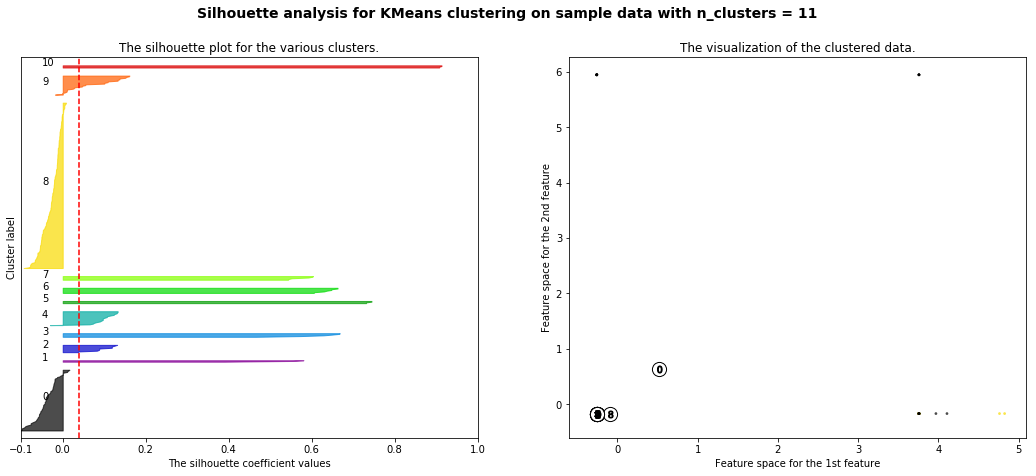

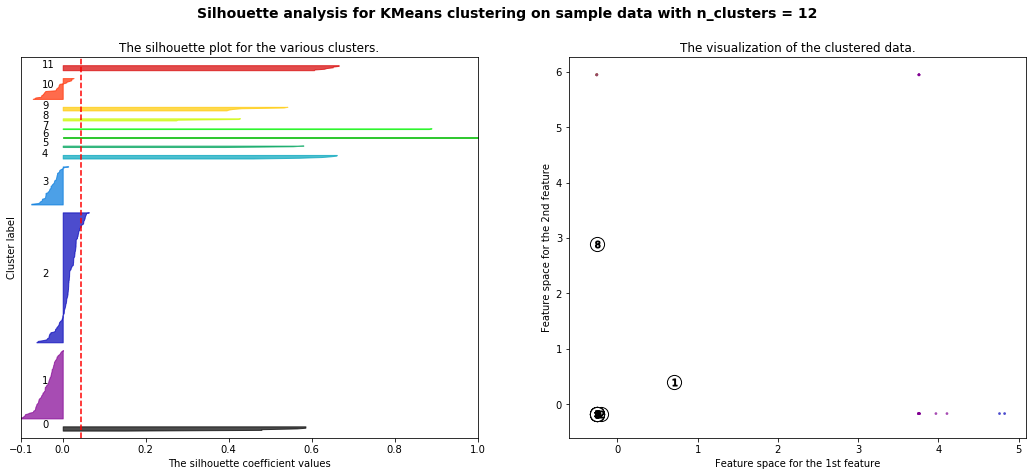

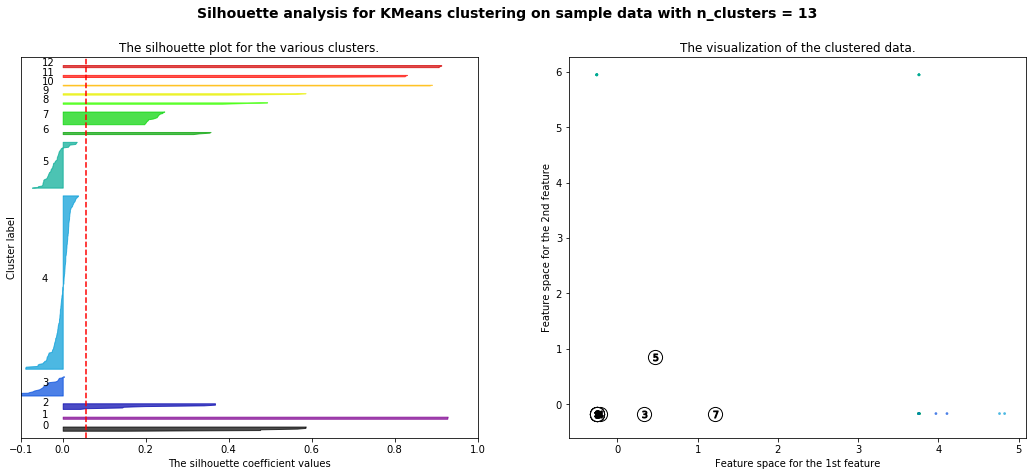

In [186]:
chooseKSilhouette(pd.DataFrame(subway_OneHot_grouped_clustering),14)

### Fit k-means
Based on previous analysis, k=14 is the number of clusters because it is the one with more valid clusters (no negative silhouette).

In [122]:
# set number of clusters
kclusters = 13

# run k-means clustering
kmeans = KMeans(init="k-means++", n_init=20, n_clusters=kclusters, random_state=10, algorithm='elkan').fit(subway_OneHot_grouped_clustering)

In [123]:
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:kclusters] 

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

Final dataframe with labels

In [124]:
subway_cluster=subway_sorted

In [125]:
subway_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

In [126]:
subway_cluster.head()

,Cluster Labels,Subway Entrance,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,103rd St & Roosevelt Ave at NE corner,Latin American Restaurant,Mexican Restaurant,Deli / Bodega,Pizza Place,Pharmacy,Food Truck,South American Restaurant,Bank,Gym,Coffee Shop
1,4,103rd St & Roosevelt Ave at SE corner,Latin American Restaurant,Mexican Restaurant,Deli / Bodega,Pizza Place,Pharmacy,Food Truck,South American Restaurant,Bank,Gym,Coffee Shop
2,4,104th St & Jamaica Ave at NE corner,Peruvian Restaurant,Deli / Bodega,Chinese Restaurant,Liquor Store,Bakery,Moving Target,Lounge,Bookstore,Park,Bagel Shop
3,4,104th St & Jamaica Ave at SE corner,Peruvian Restaurant,Deli / Bodega,Chinese Restaurant,Pharmacy,Convenience Store,Mexican Restaurant,Metro Station,Park,Bar,Market
4,4,10th Ave & 207th St at NW corner,Lounge,Pizza Place,Café,Grocery Store,Mexican Restaurant,Juice Bar,Nightclub,Food Truck,Bank,Bakery


In [127]:
dfSubwayEntrances_merged = dfSubwayEntrances
dfSubwayEntrances_merged = dfSubwayEntrances_merged.join(subway_cluster.set_index('Subway Entrance'), on='Subway Entrance')

dfSubwayEntrances_merged.head(2)

,Subway Entrance,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Birchall Ave & Sagamore St at NW corner,40.849169,-73.868356,4,Deli / Bodega,Pizza Place,Garden,Pool Hall,Park,Paper / Office Supplies Store,Hookah Bar,Moving Target,Liquor Store,Spanish Restaurant
1,Birchall Ave & Sagamore St at NE corner,40.849128,-73.868213,4,Deli / Bodega,Pizza Place,Garden,Pool Hall,Park,Paper / Office Supplies Store,Hookah Bar,Moving Target,Liquor Store,Spanish Restaurant


In [128]:
dfSubwayEntrances_merged['Cluster Labels'].unique()

array([ 4,  5, 10,  3, 11, 12,  2,  7,  8,  0,  9,  1,  6])

In [174]:
colors_array_names=[
    'red', 
    'seagreen',
    'steelblue',
    'tomato',
    'yellow',
    'y',
    'magenta',
    'dodgerblue',
    'darkblue',
    'lime',
    'blueviolet',
    'purple',
    'peru',
    'black',
    'rebeccapurple',
    'pink'
]

colors_array_hex=[
    colors.to_hex('r'), 
    colors.to_hex('seagreen'),
    colors.to_hex('steelblue'),
    colors.to_hex('tomato'),
    colors.to_hex('yellow'),
    colors.to_hex('y'),
    colors.to_hex('magenta'),
    colors.to_hex('dodgerblue'),
    colors.to_hex('darkblue'),
    colors.to_hex('lime'),
    colors.to_hex('blueviolet'),
    colors.to_hex('purple'),
    colors.to_hex('peru'),
    colors.to_hex('black'),
    colors.to_hex('rebeccapurple'),
    colors.to_hex('pink')
]

In [175]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(dfSubwayEntrances_merged['Latitude'], dfSubwayEntrances_merged['Longitude'], dfSubwayEntrances_merged['Subway Entrance'], dfSubwayEntrances_merged['Cluster Labels']):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        color=colors_array_hex[cluster-1],
        fill=True,
        #fill_color=rainbow[cluster-1]
        fill_color=colors_array_hex[cluster-1]
    ).add_to(map_clusters)
       
map_clusters

Based on silhouette analysis, clusters 5-9-11 are not valid so I won't consider them.

In [131]:
mask = (dfSubwayEntrances_merged['Cluster Labels'] != 3) & (dfSubwayEntrances_merged['Cluster Labels'] != 4) & (dfSubwayEntrances_merged['Cluster Labels'] != 5)
dfSubwayEntrances_merged_final=dfSubwayEntrances_merged.loc[mask]

Plot with legend

In [176]:
colors_array_names

['red',
 'seagreen',
 'steelblue',
 'tomato',
 'yellow',
 'y',
 'magenta',
 'dodgerblue',
 'darkblue',
 'lime',
 'blueviolet',
 'purple',
 'peru',
 'black',
 'rebeccapurple',
 'pink']

In [184]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(dfSubwayEntrances_merged_final['Latitude'], dfSubwayEntrances_merged_final['Longitude'], dfSubwayEntrances_merged_final['Subway Entrance'], dfSubwayEntrances_merged_final['Cluster Labels']):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        color=colors_array_hex[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1]
        fill_color=colors_array_hex[cluster]
    ).add_to(map_clusters)
    
    
    
    
    
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend:</div>
<div class='legend-scale'>
  <ul class='legend-labels' data-columns="2">
    <li><span style='background:red;opacity:0.7;'></span>Cluster 0</li>
    <li><span style='background:seagreen;opacity:0.7;'></span>Cluster 1</li>
    <li><span style='background:steelblue;opacity:0.7;'></span>Cluster 2</li>
    <li><span style='background:magenta;opacity:0.7;'></span>Cluster 6</li>
    <li><span style='background:dodgerblue;opacity:0.7;'></span>Cluster 7</li>
    <li><span style='background:darkblue;opacity:0.7;'></span>Cluster 8</li>
    <li><span style='background:lime;opacity:0.7;'></span>Cluster 9</li>
    <li><span style='background:blueviolet;opacity:0.7;'></span>Cluster 10</li>
    <li><span style='background:purple;opacity:0.7;'></span>Cluster 11</li>
    <li><span style='background:peru;opacity:0.7;'></span>Cluster 12</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

map_clusters.get_root().add_child(macro)

map_clusters

## Clusters Analysis

In [138]:
#dfSubwayEntrances_merged.loc[dfSubwayEntrances_merged['Cluster Labels']==3]

In [211]:
# Number of clusters
# Positions
# value for each positions
clustersChar=getClusterCommonVenues(dfSubwayEntrances_merged_final,kclusters,3,2)

In [212]:
clustersChar.head(100)

,Venue Position,Venue Type,Counts,Total
Cluster,,,,
0,1st Most Common Venue,Restaurant; Beach,3; 3,7
0,2nd Most Common Venue,Gourmet Shop; Eastern European Restaurant,3; 2,7
1,1st Most Common Venue,Cantonese Restaurant,4,4
1,2nd Most Common Venue,Sushi Restaurant,4,4
2,1st Most Common Venue,Coffee Shop; Italian Restaurant,4; 4,9
2,2nd Most Common Venue,Café; Donut Shop,5; 1,9
6,1st Most Common Venue,Yoga Studio; Gym / Fitness Center,2; 2,4
6,2nd Most Common Venue,Gym; Yoga Studio,2; 1,4
7,1st Most Common Venue,Theater; Hotel,15; 4,19


In [213]:
clustersChar.to_csv(fileRes,sep=',')